# (для google colaboratory)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# !pip uninstall keras
# !pip uninstall tensorflow
# !pip uninstall tensorflow-gpu

# !pip install tensorflow-gpu==1.13.1
# !pip install keras==2.2.5
# !pip install mrcnn
# !pip install imgaug

# О выбранной модели и реализации

1. **Модель**   
После прочтения статей [[1]](https://habr.com/ru/post/421299/), [[2]](https://habr.com/ru/company/newprolab/blog/412523/), [[3]](https://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset) было решено использовать в качестве основной модели именно *Mask-R CNN*. Эта модель как раз работает с масками изображений и bounding box'ами.  
 *MRCNN* показывает неплохие результаты в задаче сегментации, а также ее выходы можно использовать для классификации, если есть необходимость различать разные типы похожих обьектов (например, хороший омлет и плохой омлет).
 
2. **Реализация**  
Было найдено несколько реализаций этой нейросети, больше всего понравилась реализация от *matterport* [[source]](https://github.com/matterport/Mask_RCNN) в фреймворке *Keras*.  
У автора очень богатая документация с иллюстрациями и пояснениями.

3. **Аугментация**  
 * Для ознакомления с методами аугментации была прочитана статья [Classifying plankton with deep neural networks](https://benanne.github.io/2015/03/17/plankton.html). Статья написана очень подробно и содержит в себе разные способы аугментации. Многое реализовать в моей задаче я не успел.  
 * Использовалась библиотека *imgaug* [[source]](https://github.com/aleju/imgaug). Порадовала обширная документация, с изображениями. А так же очень простое использование на практике.
 * Использованные преобразования изображений:  
 1) Аддитивный гауссовский шум  
 2) SaltAndPepper  
 3) Аффинное преобразование (сдвиг на случайный угол)  
 Также описаны в моем пакете *lib/augmentation.py*:  
 4) Изменение перспективы  
 5) Изменение контраста  
 6) Изменение резскости  
 7) Повороты, отражения  
 Были использованы только первые три ввиду долгого времени обучения.
 * В итоге, для обучающего сета было подготовлено *8000 изображений*.   
Изображения: *data/train/augmented*. Аннотации к ним: *data/train*.













# Imports

In [0]:
import os
os.chdir('./drive/My Drive/cigarette_butt_segmentation')

from lib import *

from PIL import Image, ImageDraw
import numpy as np

import mrcnn.config
import mrcnn
from mrcnn import visualize
from mrcnn.model import MaskRCNN
from mrcnn import utils

# Создание датасета для дообучения сети

Методы создания датасета в *lib/contructing_datasets.py*.  
Для загрузки изображений и их аннотаций используется метод *load_data*.  
Перед дальнейшим использований вызвать метод *prepare*

### Обучающий датасет

In [0]:
%%time
train_set = buttsDataset()
train_set.load_data('./data/train/coco_annotations.json', './data/train/images')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 2000
CPU times: user 43.6 ms, sys: 5.17 ms, total: 48.7 ms
Wall time: 59.2 ms


### Обучающий датасет с аугментацией

In [0]:
%%time
# Запускает процесс аугментации. На каждое изображение из датасета генерирует
# число новых изображений, равное ratio. Каждое новое изображение - результат
# применения одного фильтра (список фильтров приведен в начале).
# Создается также файл с аннотациями в формате COCO.
train_set.start_augmentation('./data/train', ratio=3)

| |             #                                  | 1999 Elapsed Time: 0:14:25


Augmentation ended. Check ./data/train directory.
CPU times: user 4min 38s, sys: 6.94 s, total: 4min 45s
Wall time: 14min 25s


In [0]:
%%time
train_set_aug = buttsDataset()
train_set_aug.load_data('./data/train/coco_annotations_augmented.json', './data/train/augmented')
train_set_aug.prepare()
print('Train with augmentation: %d' % len(train_set_aug.image_ids))

Train with augmentation: 8000
CPU times: user 230 ms, sys: 24.3 ms, total: 255 ms
Wall time: 269 ms


### Валидационный датасет

In [0]:
%%time
val_set = buttsDataset()
val_set.load_data('./data/val/coco_annotations.json', './data/val/images')
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))

Val: 200
CPU times: user 4.03 ms, sys: 1.01 ms, total: 5.04 ms
Wall time: 598 ms


### Картинки, иллюстрации

Посмотрим на изображения, например, из валидационного датасета и их маски.

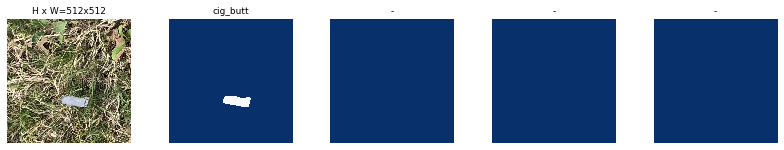

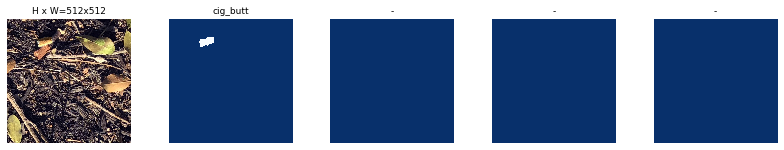

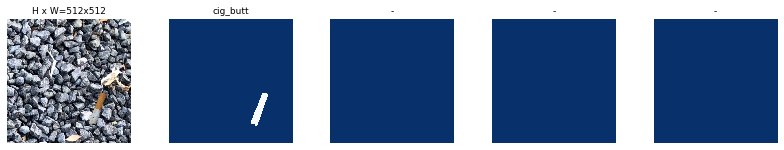

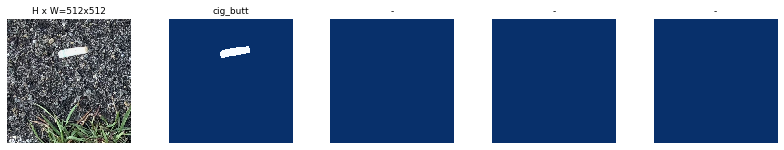

Image Count: 200
Class Count: 2
  0. BG                                                
  1. cig_butt                                          


In [0]:
image_ids = np.random.choice(val_set.image_ids, 4)
for image_id in image_ids:
    image = val_set.load_image(image_id)
    mask, class_ids = val_set.load_mask(image_id)
    visualize.display_top_masks(image, mask.reshape(512, 512, 1), class_ids, val_set.class_names)
    
print("Image Count: {}".format(len(val_set.image_ids)))
print("Class Count: {}".format(val_set.num_classes))
for i, info in enumerate(val_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

# Дообучение на подготовленных датасетах

Дообучение проводится с использованием встроенного метода *train*

### Без аугментации

In [0]:
# Создание конфигурации нейросети (параметры по умолчанию описаны в lib/mrcnnConfig).
# В данном случае изменим только число изображений за эпоху так, чтобы нейросеть за
# 4 эпохи увидела все изображения.
config = CigButtsConfig()
config.STEPS_PER_EPOCH = 500
config.display()

model = MaskRCNN(mode="training", model_dir="logs", config=config)

# Загрузка весов предобученной на множестве изображений ImageNet MRCNN.
model.load_weights('./trained_weights/mask_rcnn_cig_butts_0008.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                             "mrcnn_bbox", "mrcnn_mask"])

In [0]:
%%time
# Дообучим нашу модель на подготовленных датасетах.
model.train(train_set, val_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/cig_butts20200219T1201/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
500/500 [==============================] - 197s 395ms/step - loss: 1.4742 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.8174 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.2780 - mrcnn_mask_loss: 0.2965 - val_loss: 1.1587 - val_rpn_class_loss: 0.0072 - val_rpn_bbox_loss: 0.5019 - val_mrcnn_class_loss: 0.0333 - val_mrcnn_bbox_loss: 0.1995 - val_mrcnn_mask_loss: 0.4168
Epoch 2/4
500/500 [==============================] - 178s 357ms/step - loss: 1.2565 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.7466 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2829 - val_loss: 0.8910 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.4030 - val_mrcnn_class_loss: 0.0927 - val_mrcnn_bbox_loss: 0.1172 - val_mrcnn_mask_loss: 0.2739
Epoch 3/4
500/500 [==============================] - 179s 358ms/step - loss: 1.0791 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.6048 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.2787 - val_loss: 0.7252 - val_rpn_c

In [0]:
%%time
model.train(train_set, val_set, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")


Starting at epoch 4. LR=0.0001

Checkpoint Path: logs/cig_butts20200219T1201/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/8
500/500 [==============================] - 387s 773ms/step - loss: 0.9081 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.4547 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.2852 - val_loss: 0.7471 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.2281 - val_mrcnn_class_loss: 0.0633 - val_mrcnn_bbox_loss: 0.0637 - val_mrcnn_mask_loss: 0.3894
Epoch 6/8
500/500 [==============================] - 351s 702ms/step - loss: 0.7900 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.3505 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.2884 - val_loss: 0.7609 - val_rpn_class_loss: 9.0522e-04 - val_rpn_bbox_loss: 0.4007 - val_mrcnn_class_loss: 0.0448 - val_mrcnn_bbox_loss: 0.0468 - val_mrcnn_mask_loss: 0.2676
Epoch 7/8
500/500 [==============================] - 350s 700ms/step - loss: 0.6740 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.2889 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2615 - val_loss: 0.5946 - val_r

In [0]:
# Сохраним новые веса в отдельный файл
model.keras_model.save_weights('./trained_weights/mask_rcnn_cig_butts_retrained_wo_augmentation.h5')

### С аугментацией

In [0]:
# Проделаем все то же самое для train_set_aug
config = CigButtsConfig()
config.STEPS_PER_EPOCH = 2000
config.display()

model = MaskRCNN(mode="training", model_dir="logs", config=config)

model.load_weights('./trained_weights/mask_rcnn_cig_butts_0008.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                             "mrcnn_bbox", "mrcnn_mask"])

In [0]:
%%time
model.train(train_set_aug, val_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: logs/cig_butts20200219T0916/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
2000/2000 [==============================] - 729s 364ms/step - loss: 1.2428 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.6582 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3078 - val_loss: 1.4956 - val_rpn_class_loss: 0.0020 - val_rpn_bbox_loss: 0.7405 - val_mrcnn_class_loss: 0.0690 - val_mrcnn_bbox_loss: 0.1500 - val_mrcnn_mask_loss: 0.5341
Epoch 2/4
2000/2000 [==============================] - 709s 355ms/step - loss: 1.0123 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2893 - val_loss: 1.3394 - val_rpn_class_loss: 0.0200 - val_rpn_bbox_loss: 1.0335 - val_mrcnn_class_loss: 0.0294 - val_mrcnn_bbox_loss: 0.0895 - val_mrcnn_mask_loss: 0.1670
Epoch 3/4
2000/2000 [==============================] - 708s 354ms/step - loss: 0.9580 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.5056 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2844 - val_loss: 0.6840 - val

In [0]:
%%time
model.train(train_set_aug, val_set, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")


Starting at epoch 4. LR=0.0001

Checkpoint Path: logs/cig_butts20200219T0916/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/8
2000/2000 [==============================] - 1420s 710ms/step - loss: 0.7305 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.3267 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.2736 - val_loss: 0.7953 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.3605 - val_mrcnn_class_loss: 0.0434 - val_mrcnn_bbox_loss: 0.0432 - val_mrcnn_mask_loss: 0.3467
Epoch 6/8
2000/2000 [==============================] - 1386s 693ms/step - loss: 0.5961 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.2338 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.2665 - val_loss: 0.6770 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 0.4896 - val_mrcnn_class_loss: 0.0084 - val_mrcnn_bbox_loss: 0.0381 - val_mrcnn_mask_loss: 0.1345
Epoch 7/8
2000/2000 [==============================] - 1388s 694ms/step - loss: 0.5385 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.2591 - val_loss: 0.4744 - 

In [0]:
model.keras_model.save_weights('./trained_weights/mask_rcnn_cig_butts_retrained_with_augmentation.h5')

# Метрики и проверка качества

Посмотрим на результаты работы обученной сети на *real_test*.

Instructions for updating:
Use tf.cast instead.
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


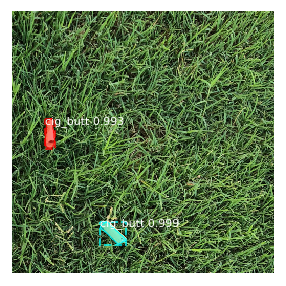

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


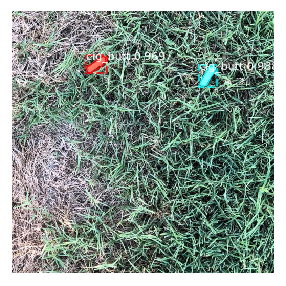

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


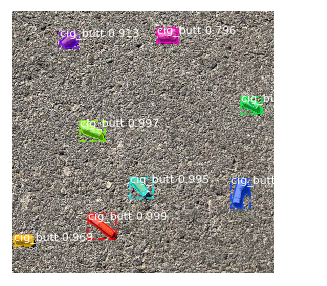

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


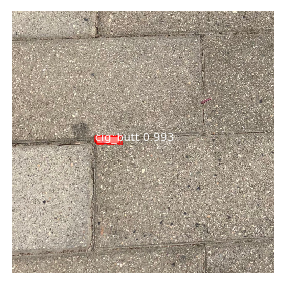

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


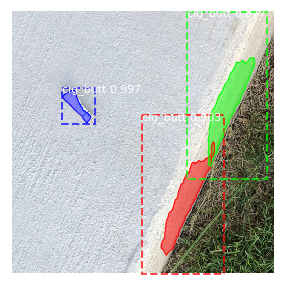

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


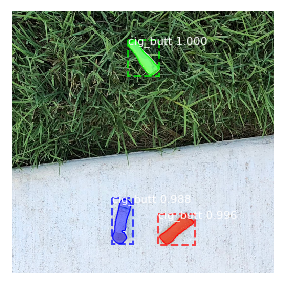

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


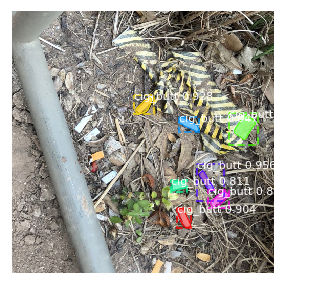

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


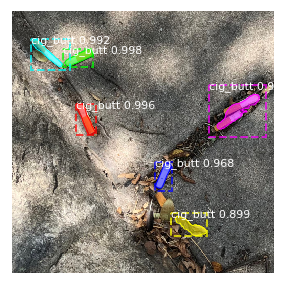

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


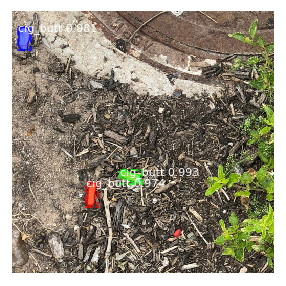

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


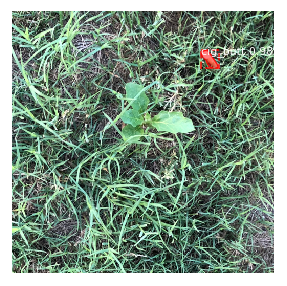

In [0]:
config = CigButtsConfig()
model = MaskRCNN(mode="inference", model_dir="logs", config=config)
model.load_weights('./trained_weights/mask_rcnn_cig_butts_retrained_with_augmentation.h5', by_name=True)

import skimage
real_test_dir = './data/real_test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                ['BG', 'cig_butt'], r['scores'], figsize=(5,5))

### Без аугментации

In [0]:
config = CigButtsConfig()
model = MaskRCNN(mode="inference", model_dir="logs", config=config)
model.load_weights('./trained_weights/mask_rcnn_cig_butts_retrained_wo_augmentation.h5', by_name=True)

In [0]:
masks_pred = []
masks_true = []
for img_id in val_set.image_ids:
    masks_true.append(val_set.load_mask(img_id)[0])
    masks_pred.append(model.detect([val_set.load_image(img_id)])[0]['masks'])

print(f'Значение метрики Dice coefficient на val_set: {get_dice(masks_true, masks_pred)}')

Значение метрики Dice coefficient на val_set: 0.8221277461262381


### С аугментацией

In [0]:
config = CigButtsConfig()
model = MaskRCNN(mode="inference", model_dir="logs", config=config)
model.load_weights('./trained_weights/mask_rcnn_cig_butts_retrained_with_augmentation.h5', by_name=True)

In [0]:
masks_pred = []
masks_true = []
for img_id in val_set.image_ids:
    masks_true.append(val_set.load_mask(img_id)[0])
    masks_pred.append(model.detect([val_set.load_image(img_id)])[0]['masks'])

print(f'Значение метрики Dice coefficient на val_set: {get_dice(masks_true, masks_pred)}')

Значение метрики Dice coefficient на val_set: 0.8423843616848987


# Анализ результатов

На реальных изображениях моя модель работает далеко не идеально, она часто принимает за окурки другие обьекты.  
Аугментация изображений дала небольшой прирост по заданной метрике.  
При этом время обучения увеличивается значительно.  
